In [3]:

import sys
sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec

import torch

import numpy as np

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger

from os.path import exists
import wget
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/home/aman.kukde/miniforge3/envs/fit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
seed_everything(22122020)

Seed set to 22122020


22122020

In [5]:
dm = MNIST_SResFITDM(root_dir='./datamodules/data/', batch_size=32)
dm.prepare_data()
dm.setup()

100%|██████████| 9912422/9912422 [00:00<00:00, 85724883.49it/s]


Extracting ./datamodules/data/MNIST/raw/train-images-idx3-ubyte.gz to ./datamodules/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 89135904.21it/s]

Extracting ./datamodules/data/MNIST/raw/train-labels-idx1-ubyte.gz to ./datamodules/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 16160928.07it/s]

Extracting ./datamodules/data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datamodules/data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17623060.84it/s]

Extracting ./datamodules/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datamodules/data/MNIST/raw



In [6]:
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)

In [7]:
n_heads = 8
d_query = 32

In [9]:
model = SResTransformerModule(d_model=n_heads*d_query, 
                              img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss='sum',
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query, dropout=0.1, attention_dropout=0.1,num_shells =5,
                              model_path ='/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/15-02_17-37-42/epoch=52-step=91107.ckpt')
import datetime

# Train your own model.
name = datetime.datetime.now().strftime("%d-%m_%H-%M-%S")
wandb_logger = WandbLogger(name = f'Run_{name}',project="MNIST",save_dir=f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}',log_model="all")
trainer = Trainer(max_epochs=100,logger=wandb_logger,
                  enable_checkpointing=True,default_root_dir = f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}', 
                                            callbacks=ModelCheckpoint(
                                            dirpath=f'/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/{name}',
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Validation/avg_val_loss',
                                            # mode='min'),limit_train_batches= 0.1,fast_dev_run=True)
                                            mode='min'))#,limit_train_batches= 0.1,fast_dev_run=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer = Trainer(max_epochs=100, 
                  gpus=1, # set to 0 if you want to run on CPU
                  callbacks=ModelCheckpoint(
                                            dirpath=None,
                                            save_top_k=1,
                                            verbose=False,
                                            save_last=True,
                                            monitor='Train/avg_val_loss',
                                            mode='min'
                                        ), 
                  deterministic=True)

In [ ]:
# Train your own model.
# trainer.fit(model, datamodule=dm);

In [ ]:
if not exists('./models/sres/mnist_sres.ckpt'):
    wget.download('https://download.fht.org/jug/fit/sres_model_mnist.ckpt',
                  out='./models/sres/mnist_sres.ckpt')

In [10]:
model.load_test_model('/home/aman.kukde/Projects/Super_Resolution_Task/Original_FIT/FourierImageTransformer/saved_models/15-02_17-37-42/epoch=52-step=91107.ckpt')
model.cpu();

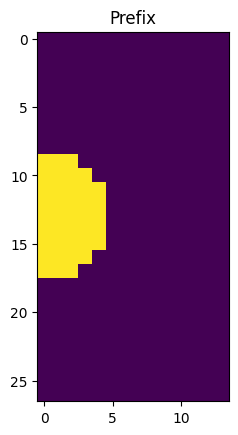

In [11]:
num_rings = 5

x, y = np.meshgrid(range(model.dft_shape[1]), range(-model.dft_shape[0] // 2 + 1, model.dft_shape[0] // 2 + 1))
radii = np.sqrt(x ** 2 + y ** 2, dtype=np.float32)
selected_rings = np.round(radii) < num_rings

model.input_seq_length = np.sum(selected_rings)
plt.imshow(selected_rings)
plt.title('Prefix');

In [12]:
for fc, (mag_min, mag_max) in dm.test_dataloader():
    break

In [13]:
lowres, pred_img, gt = model.get_lowres_pred_gt(fc, mag_min, mag_max)

/tmp/ipykernel_18480/1920324178.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(31/2., 10/2.))


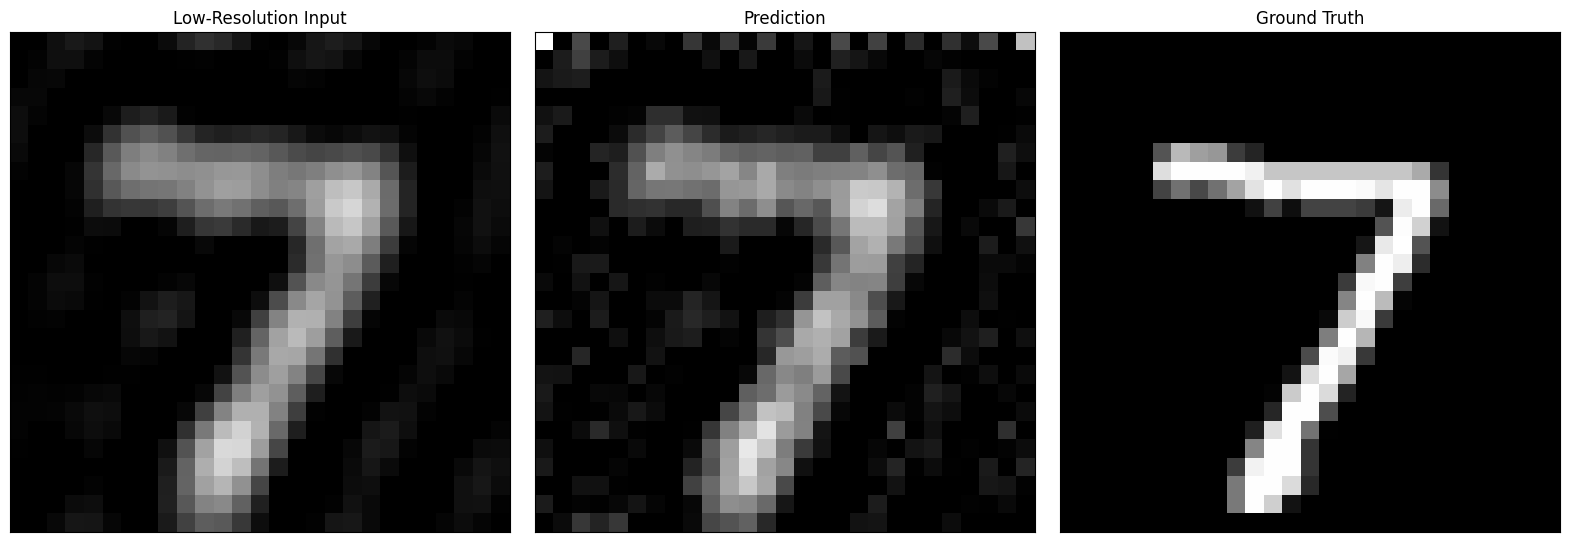

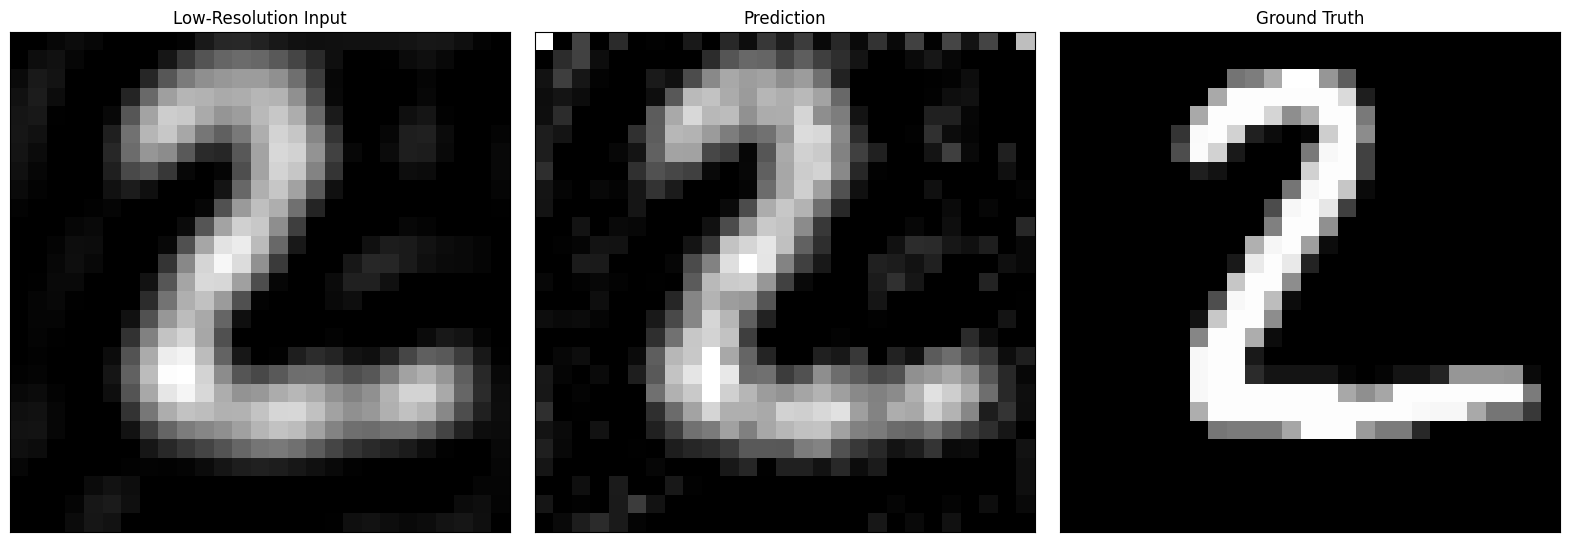

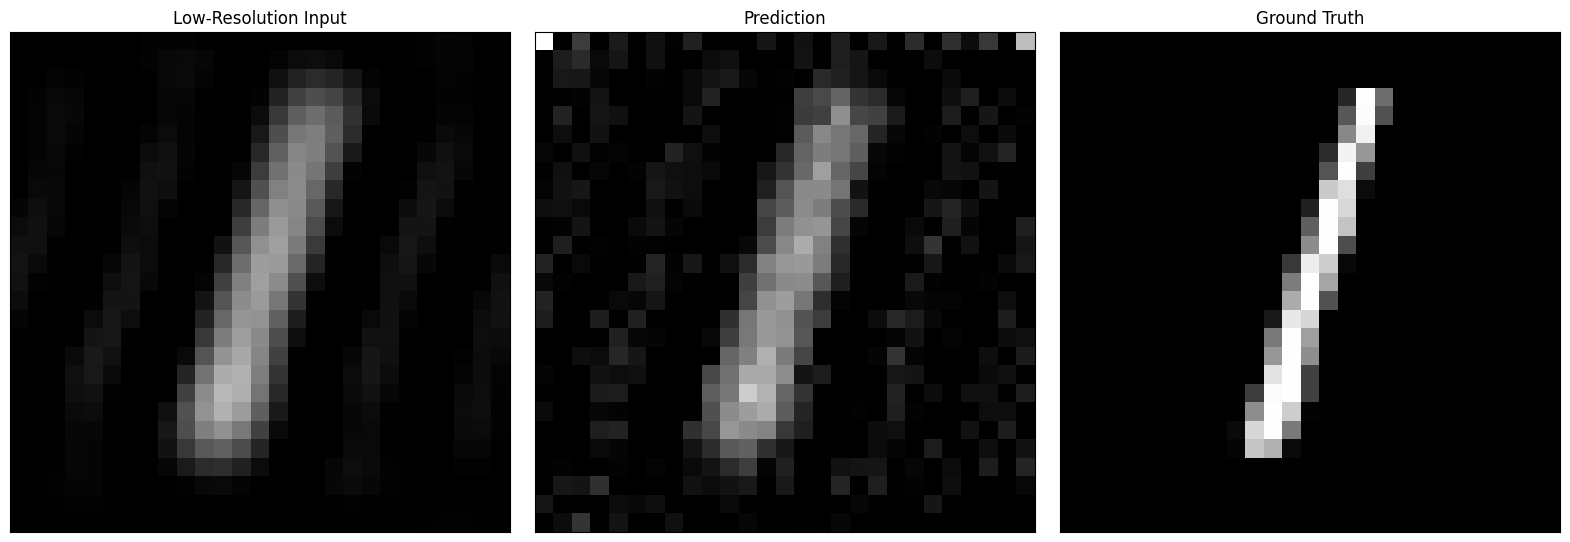

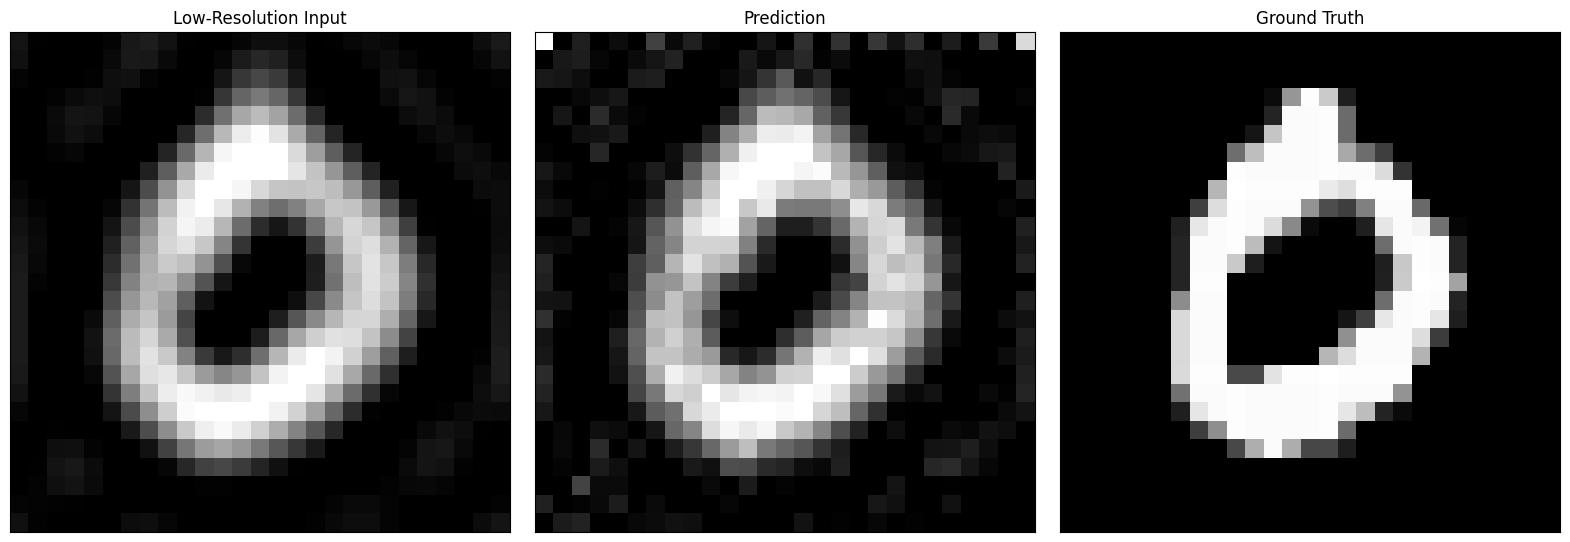

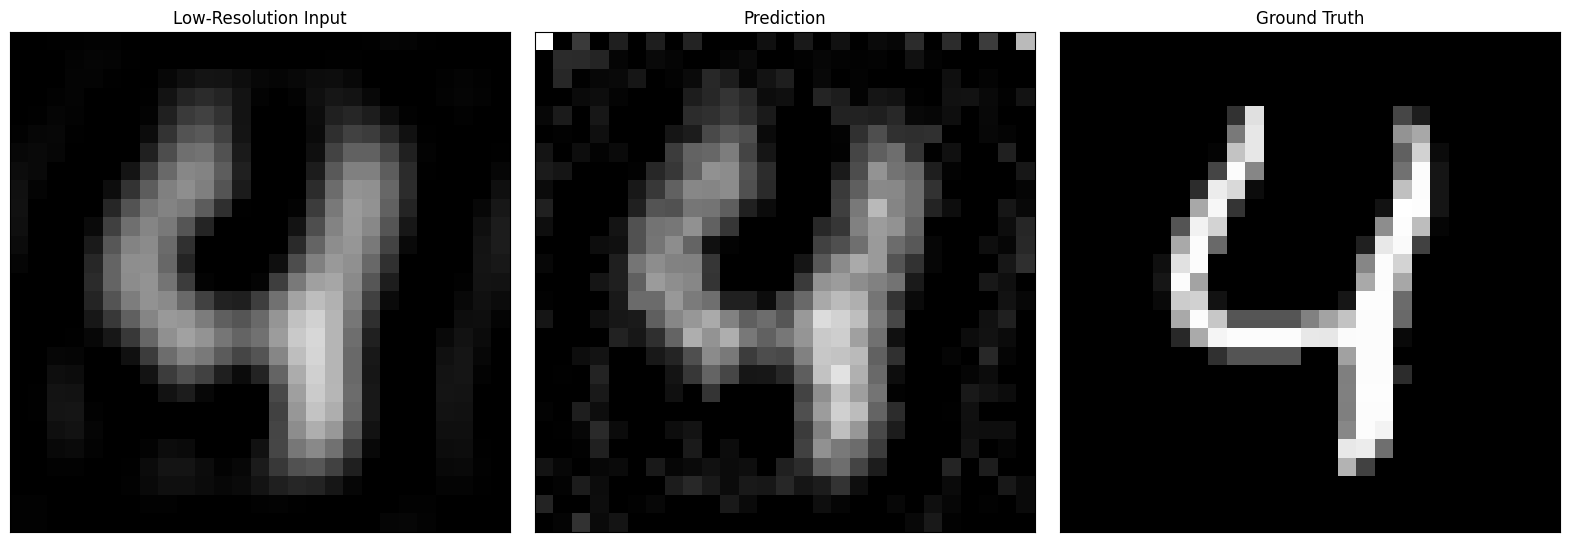

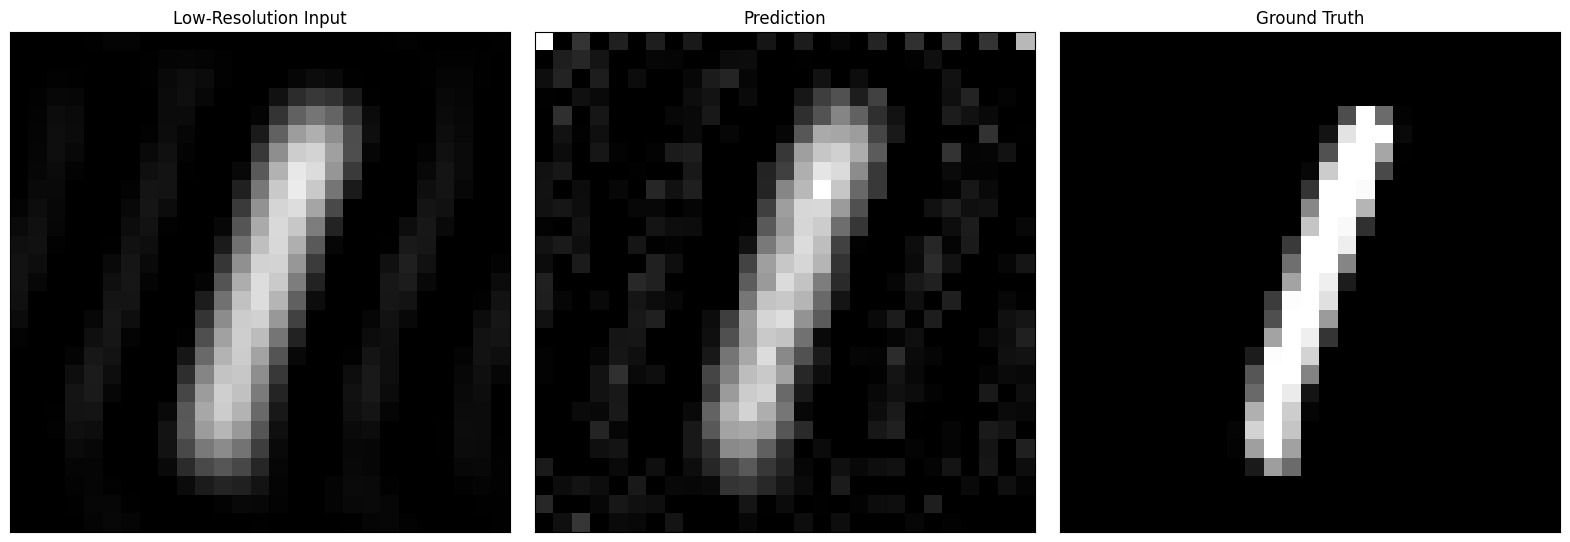

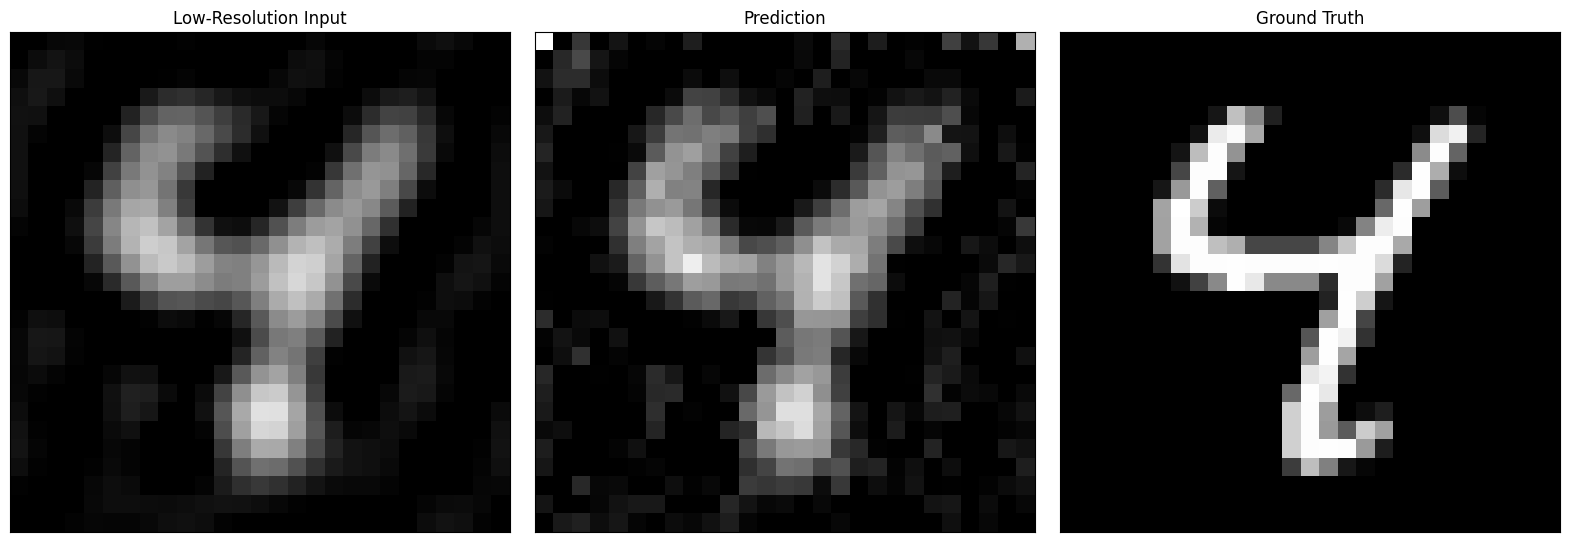

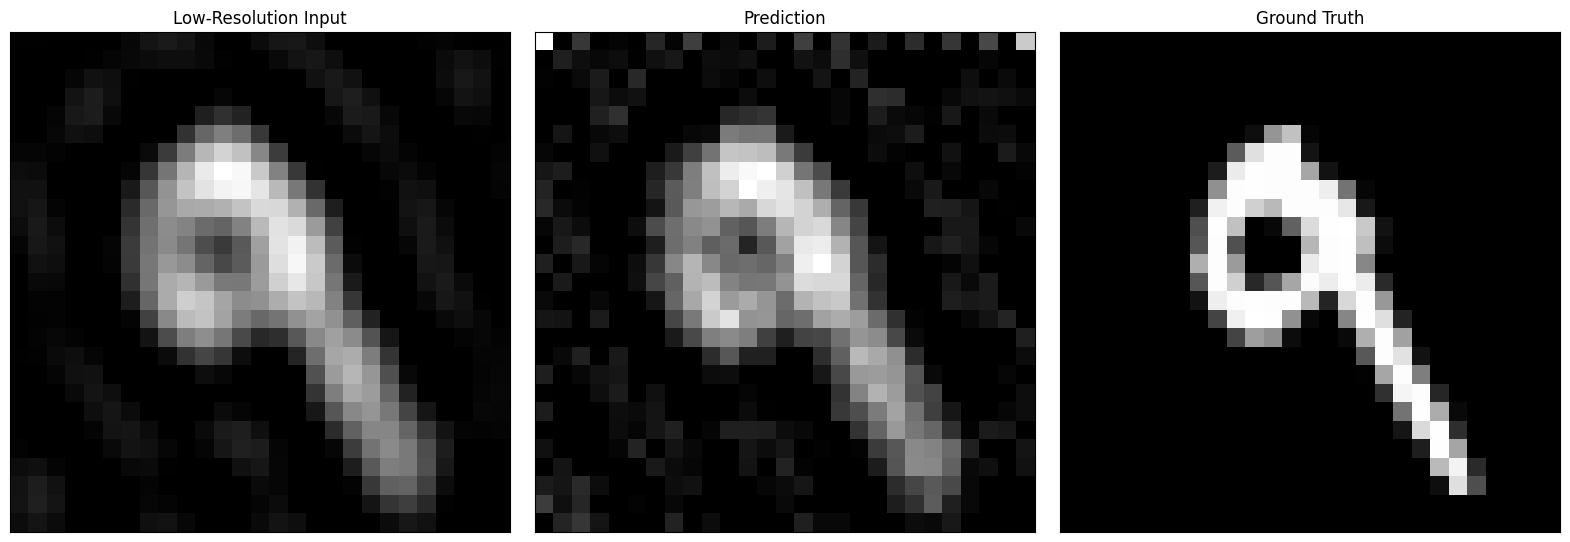

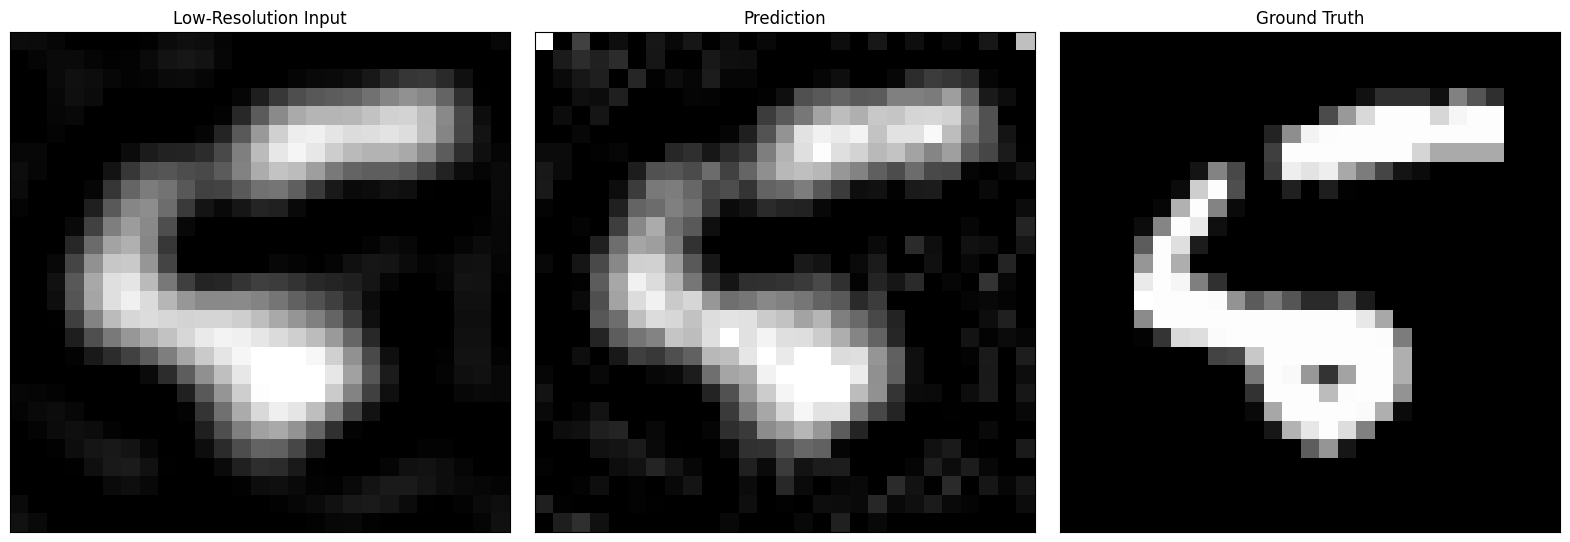

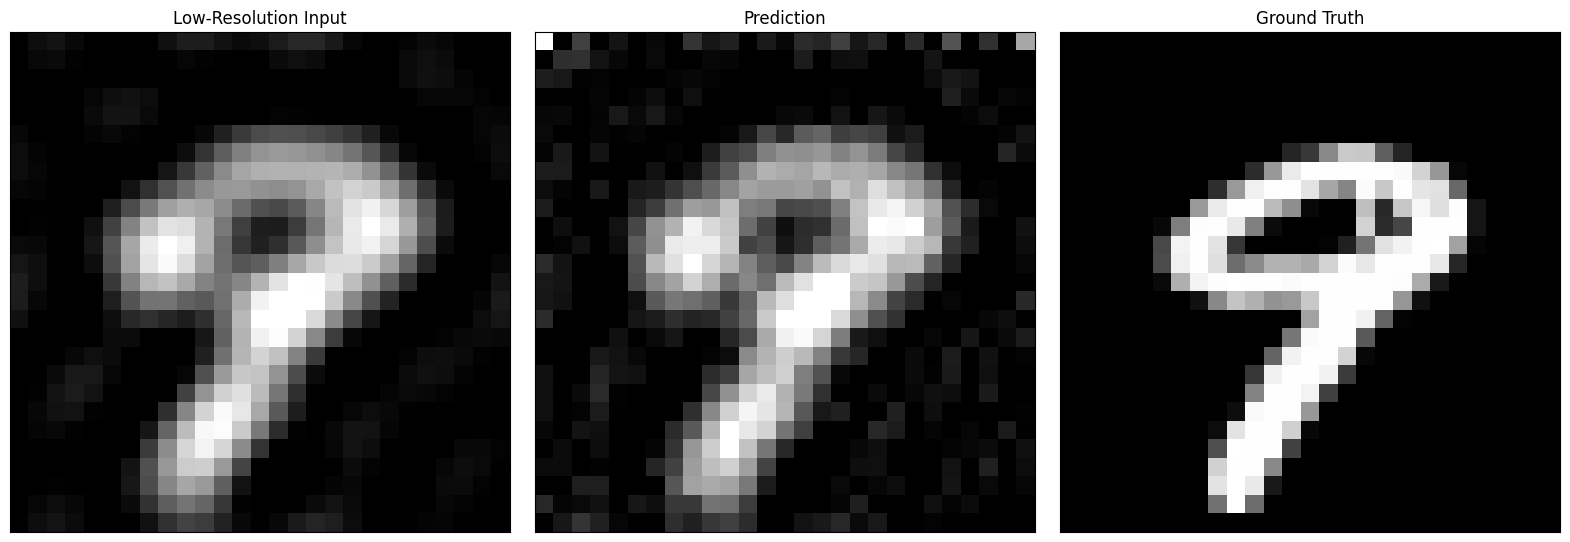

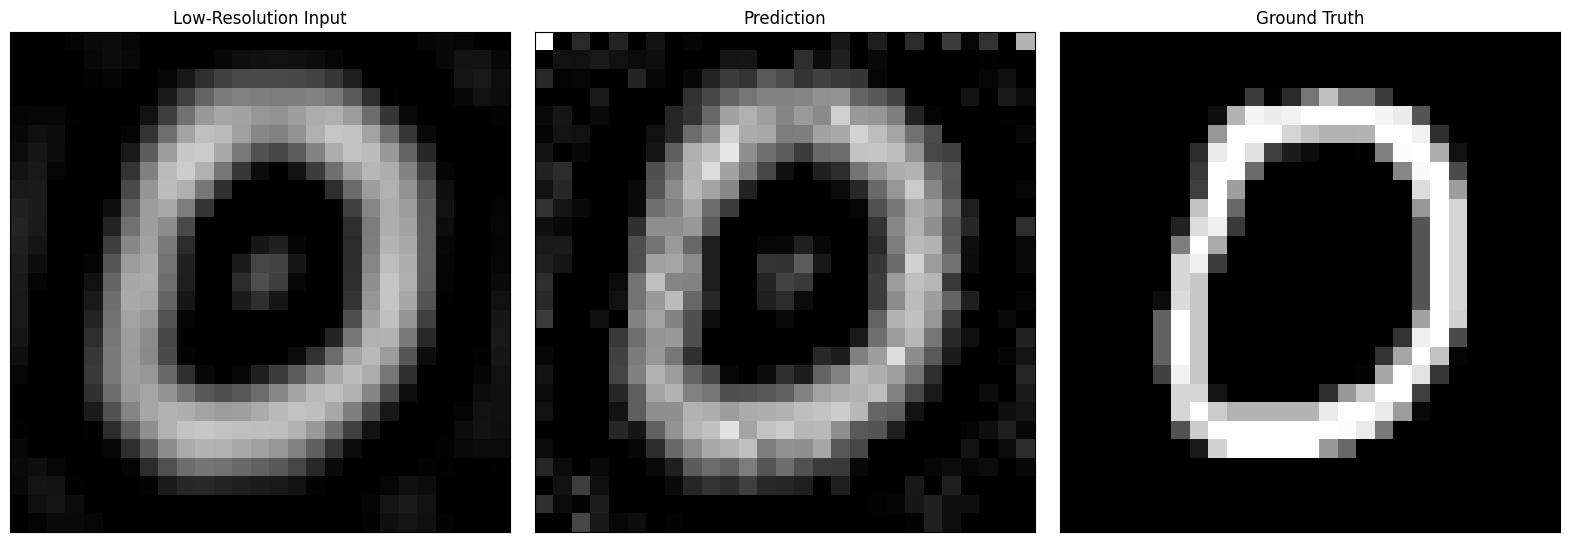

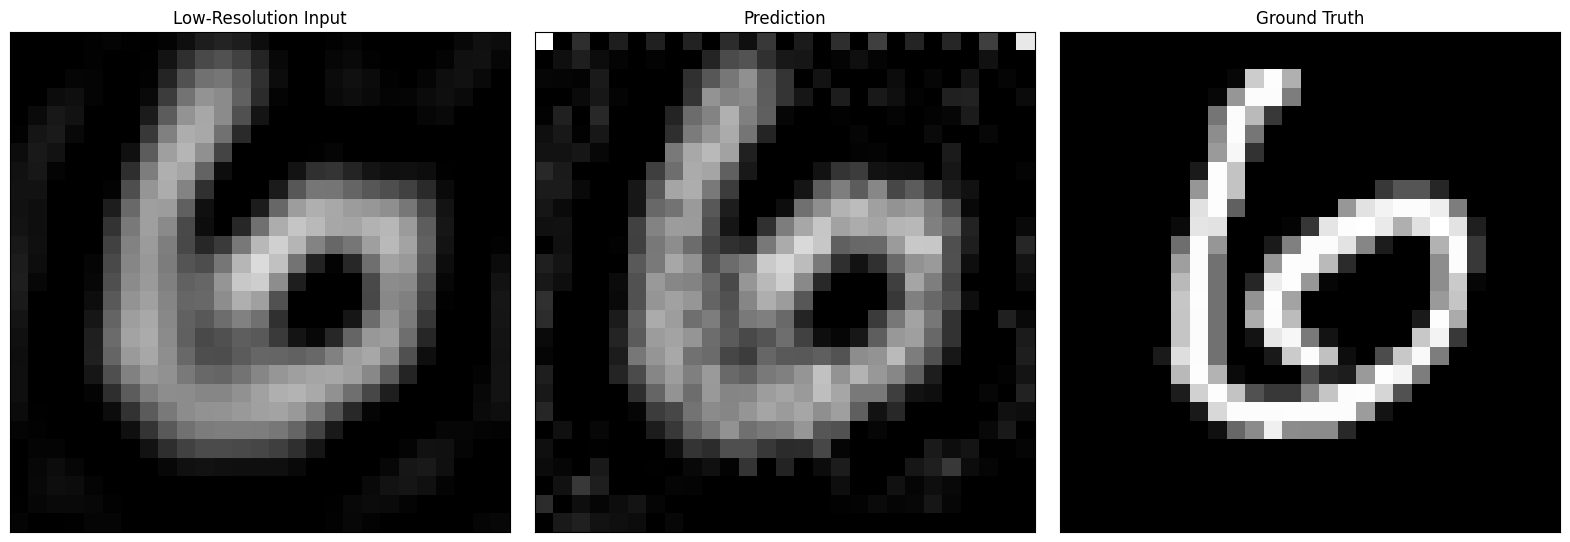

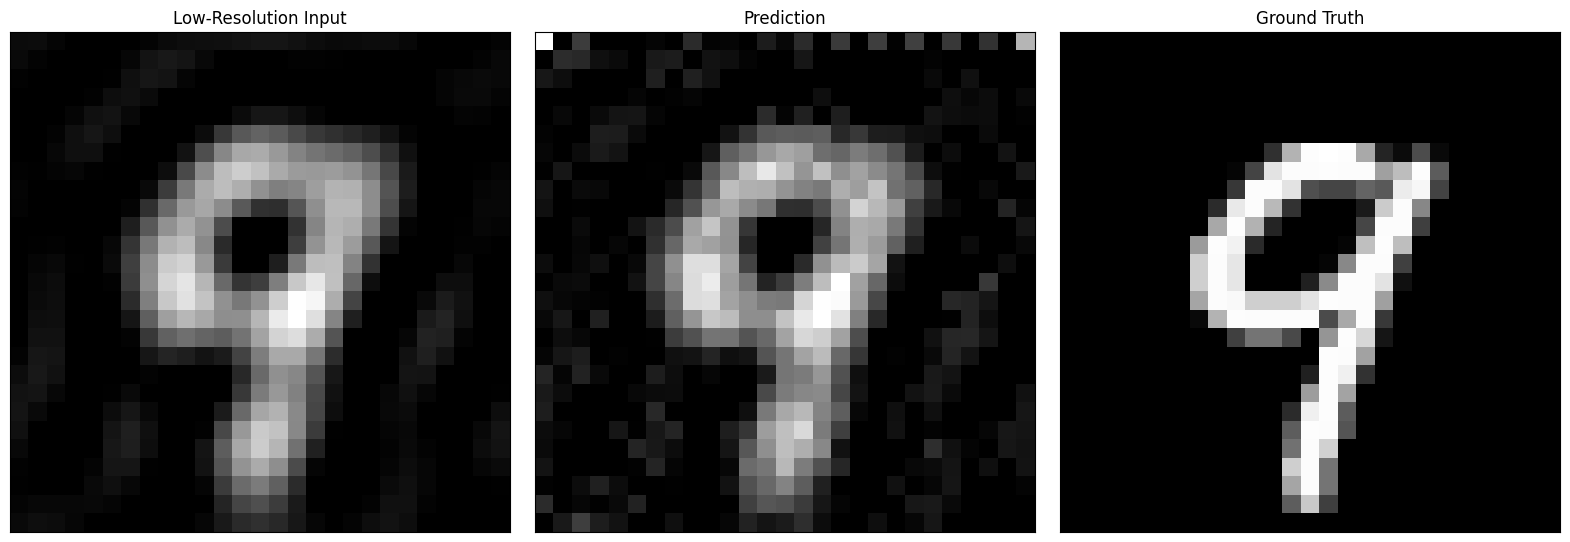

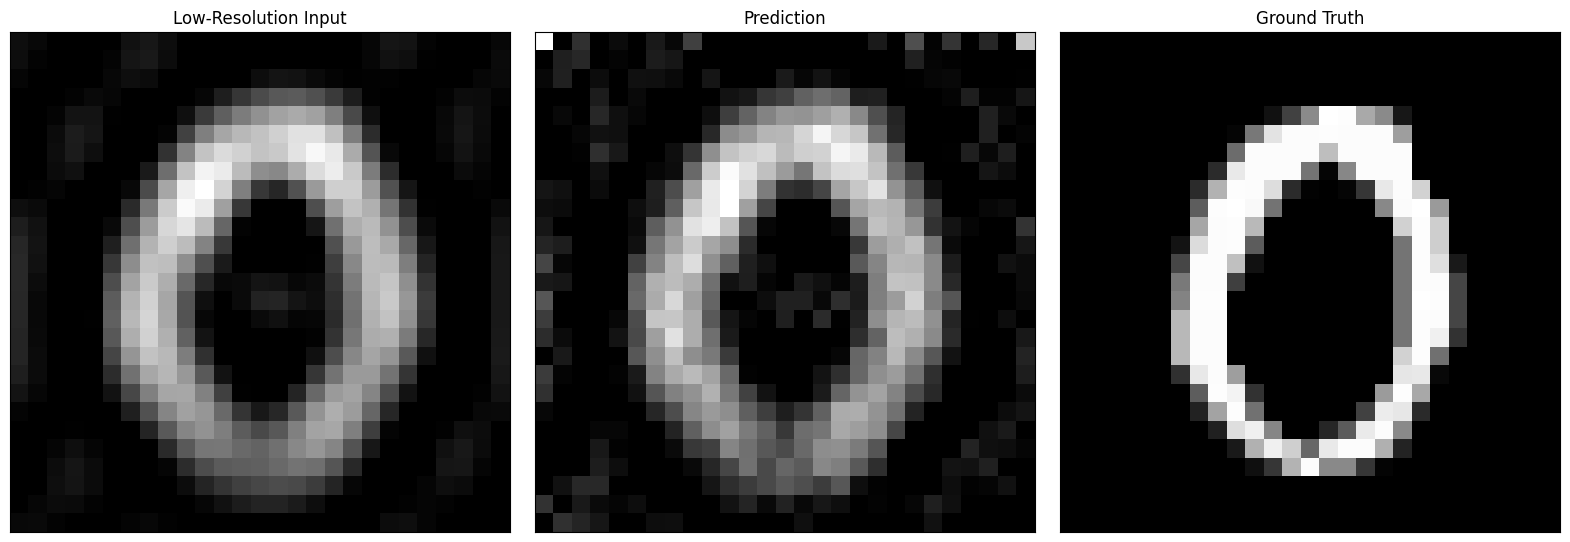

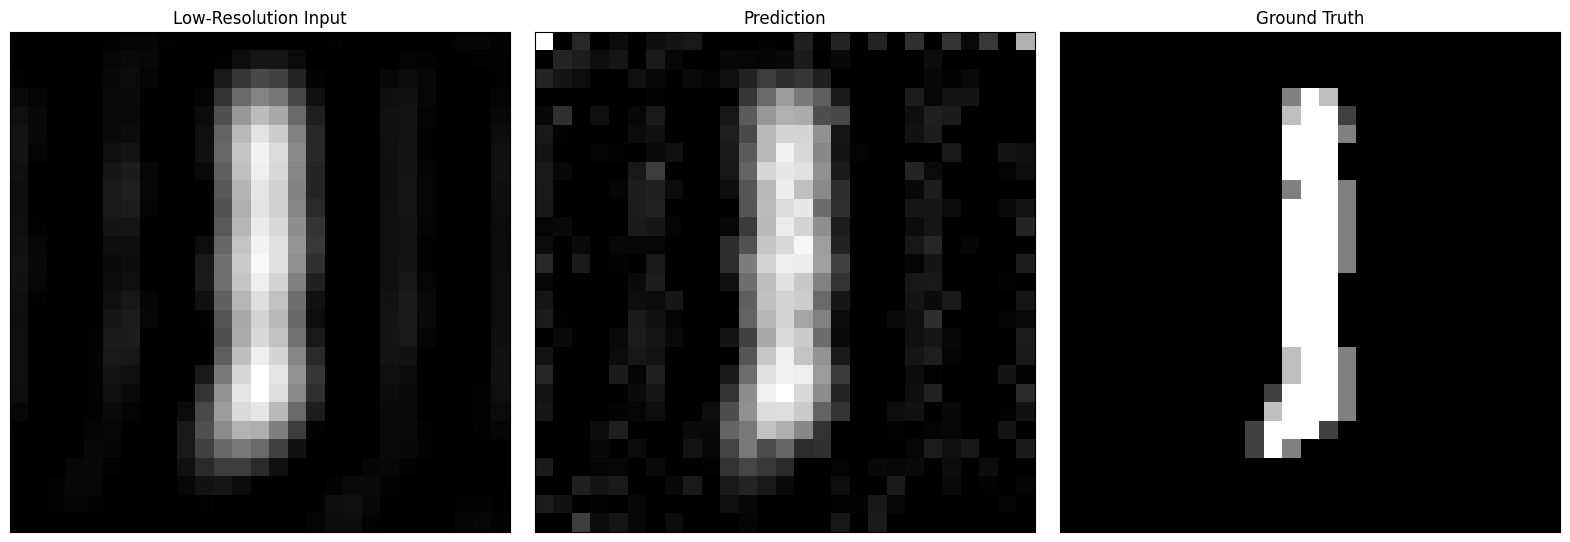

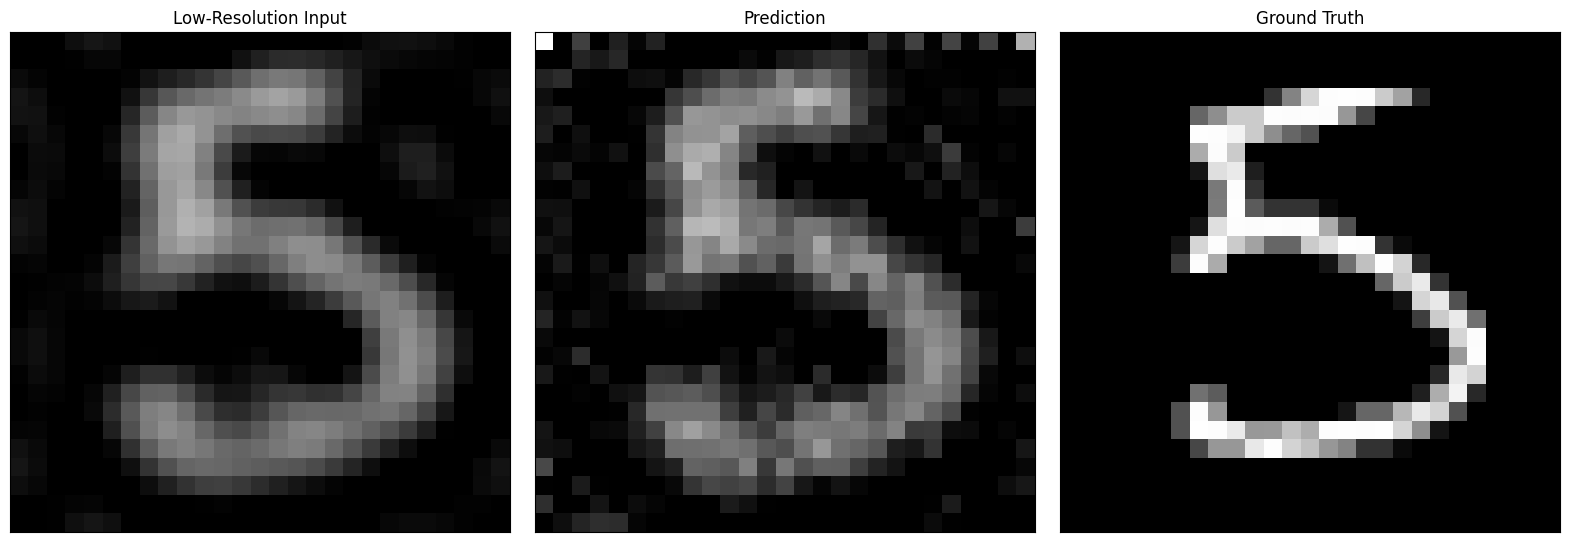

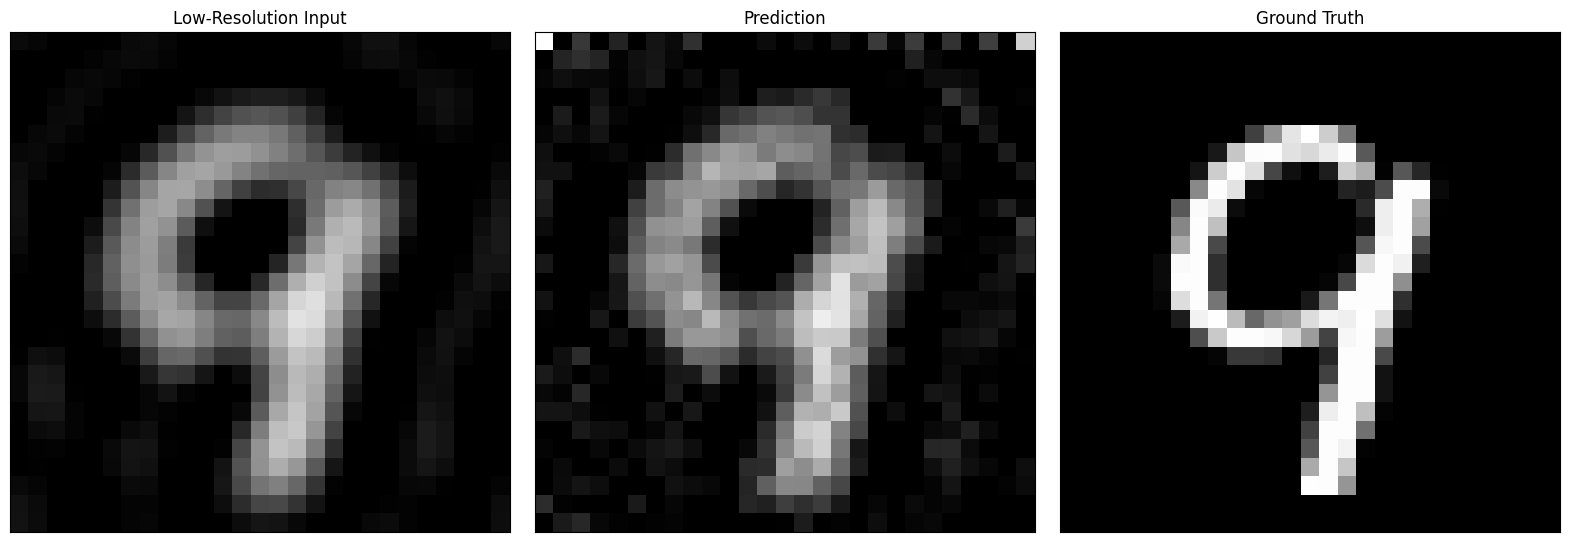

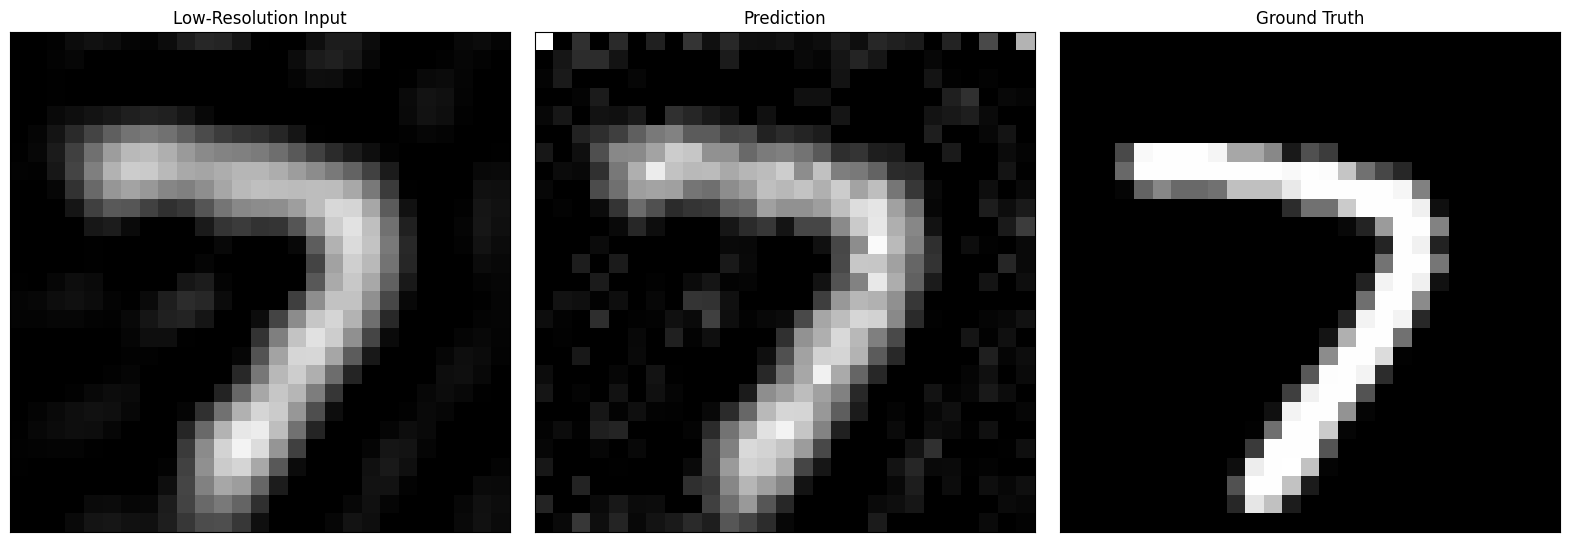

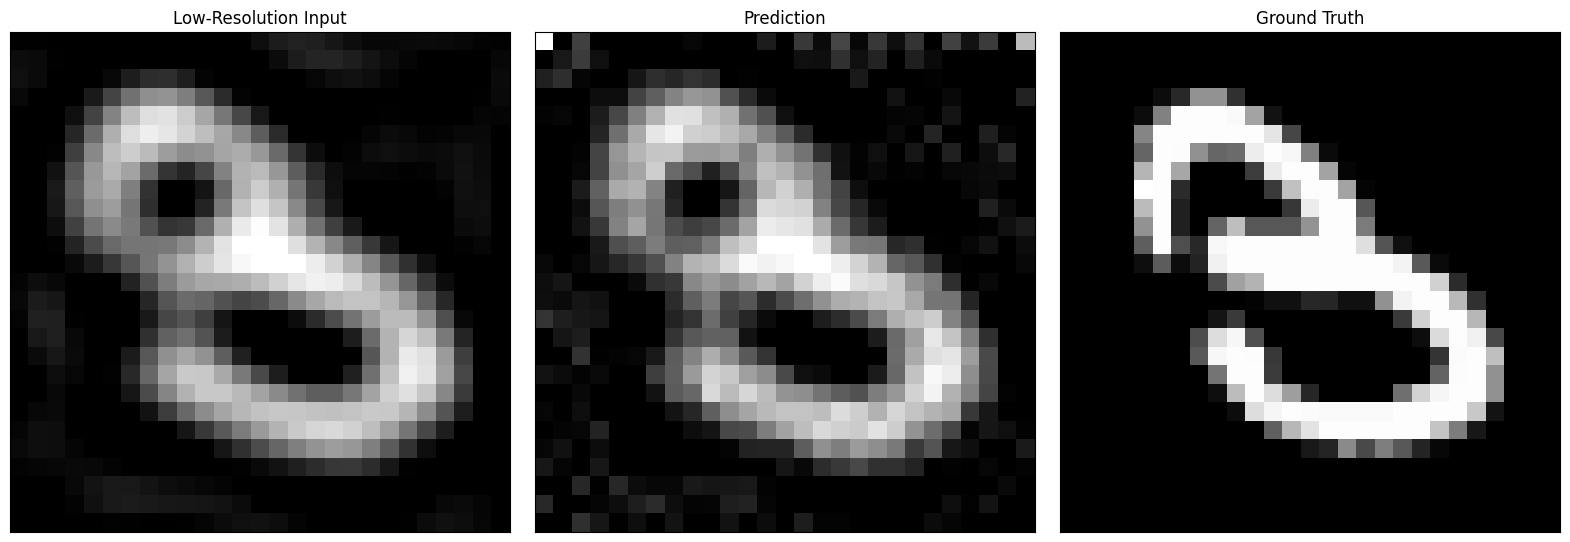

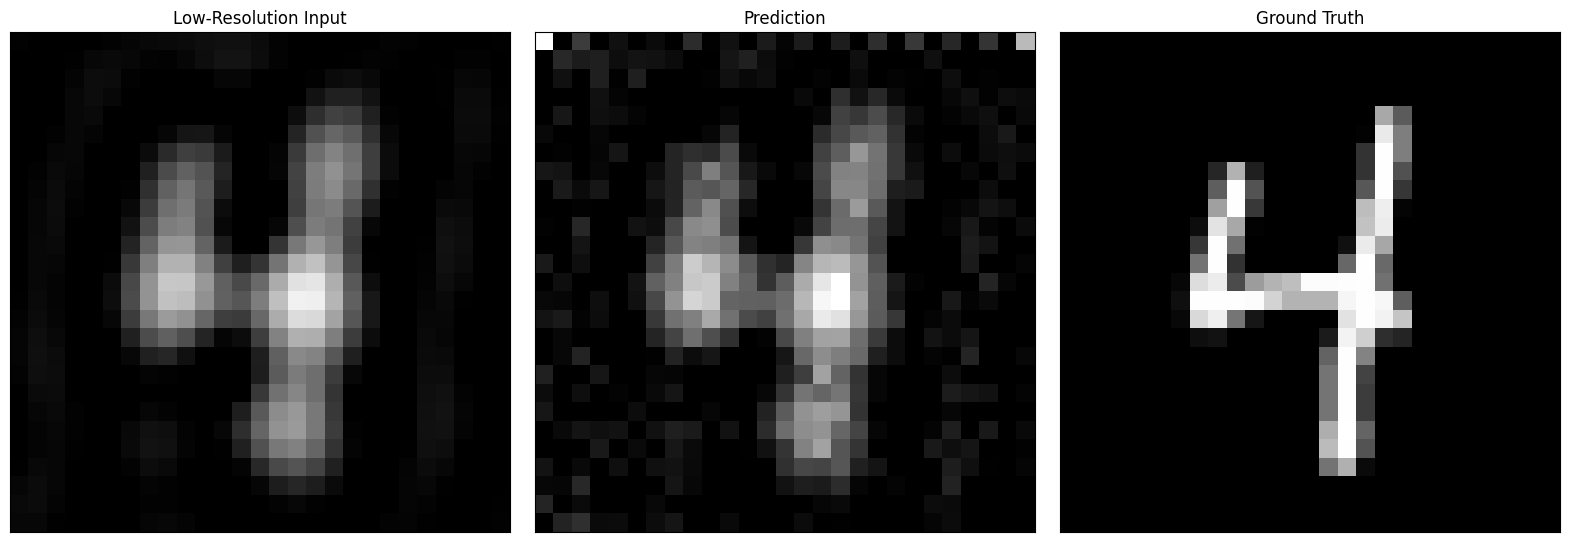

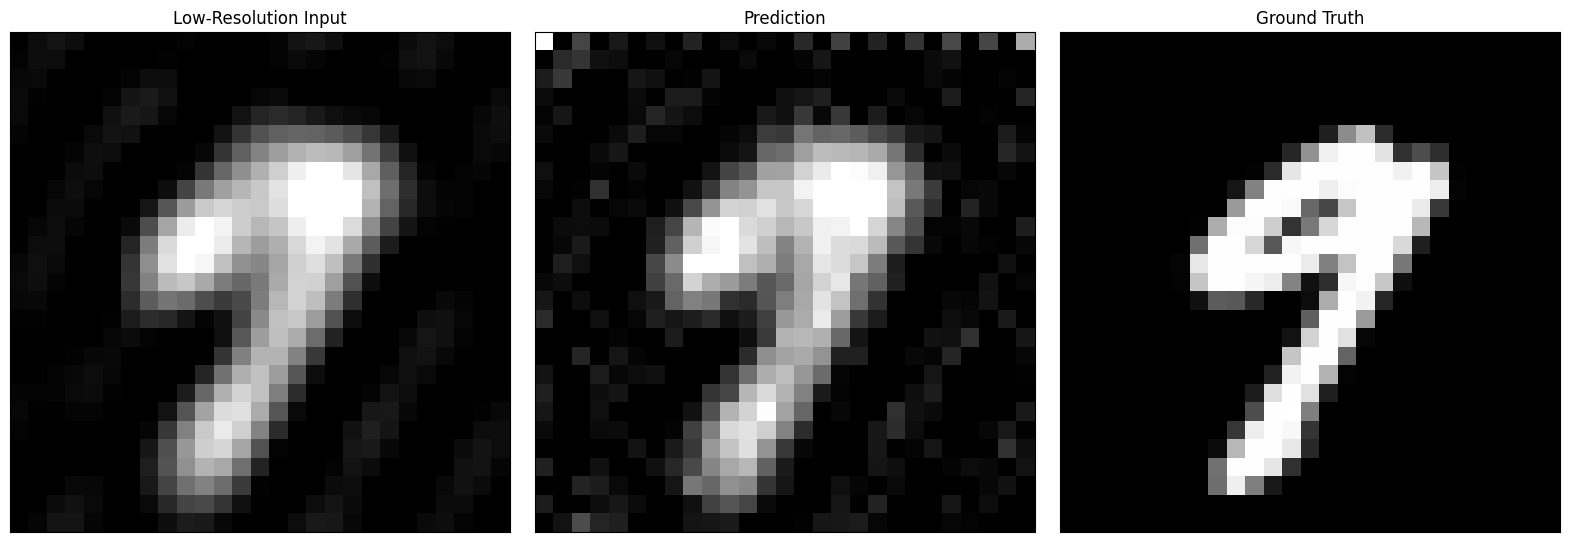

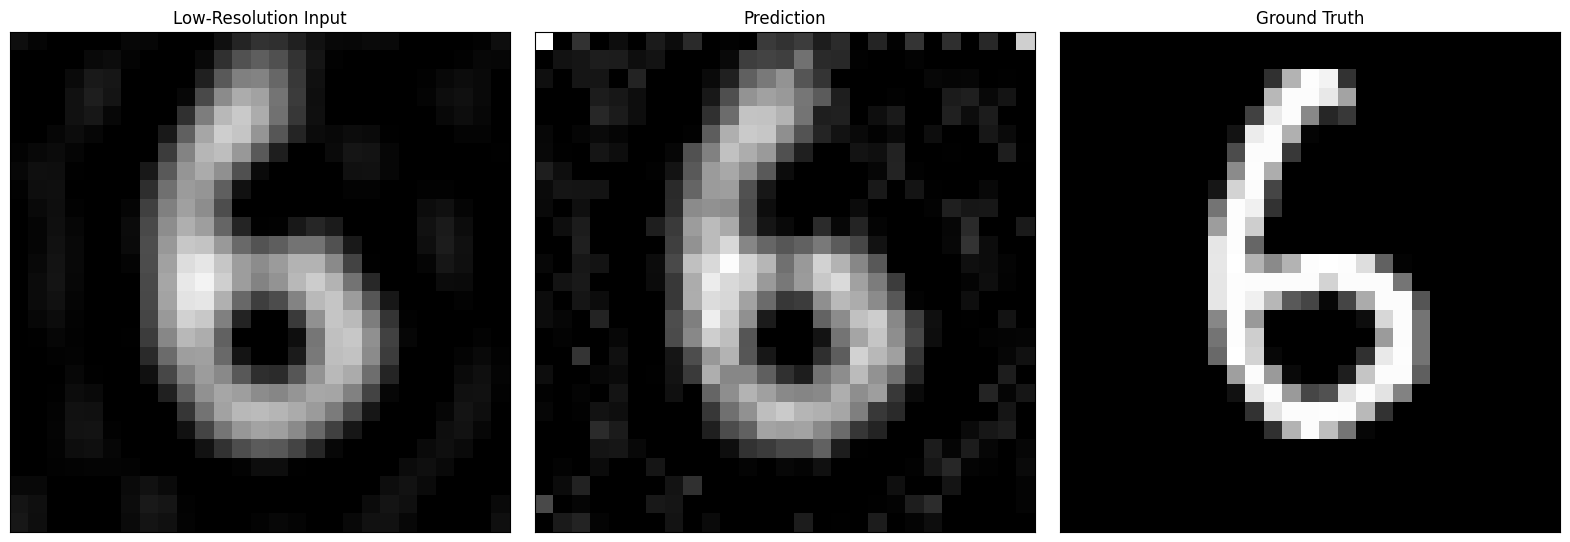

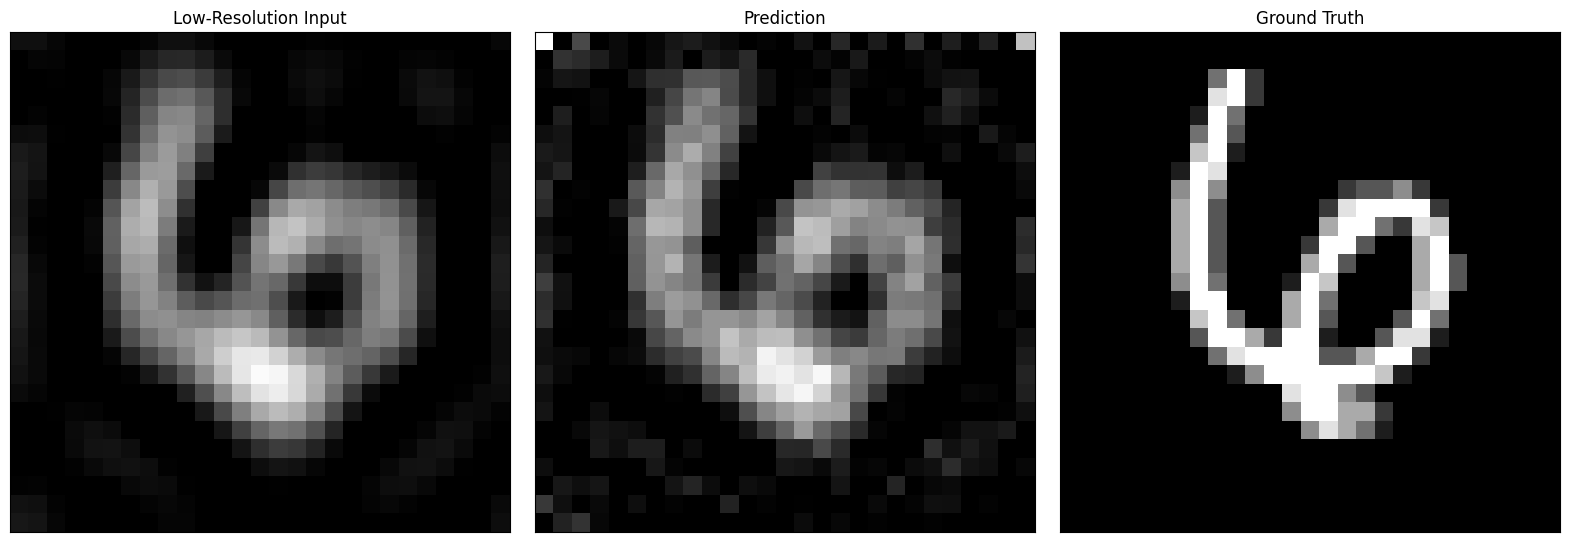

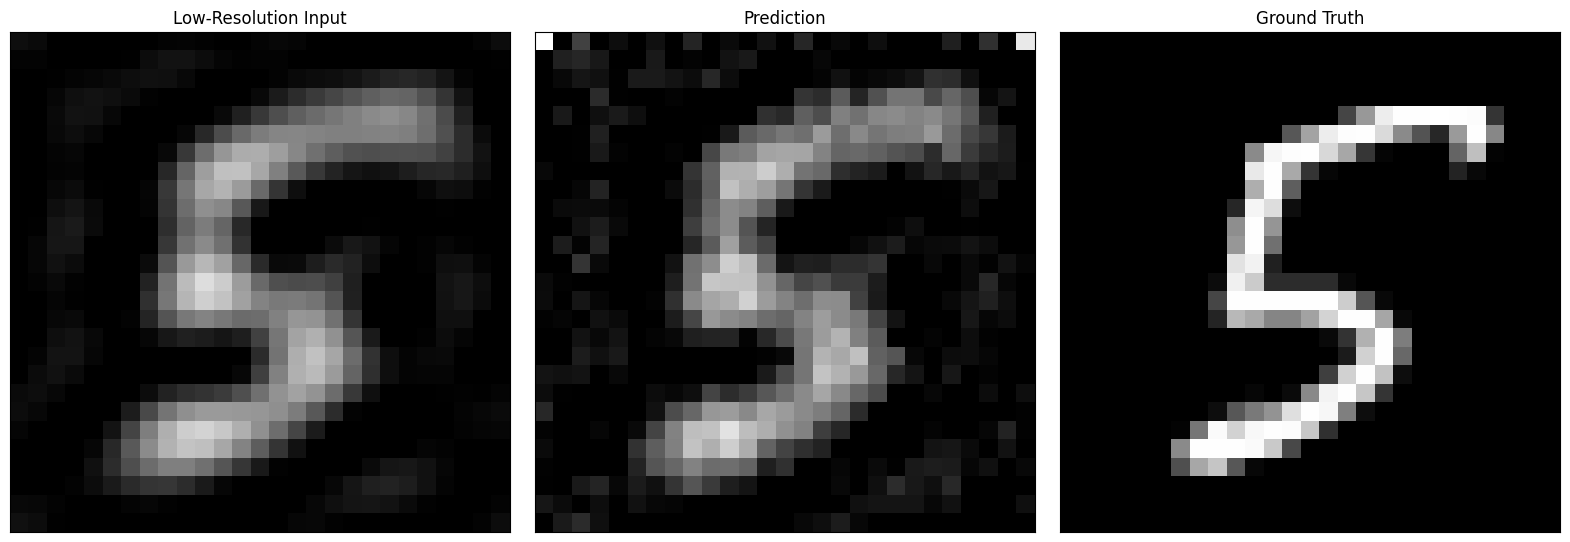

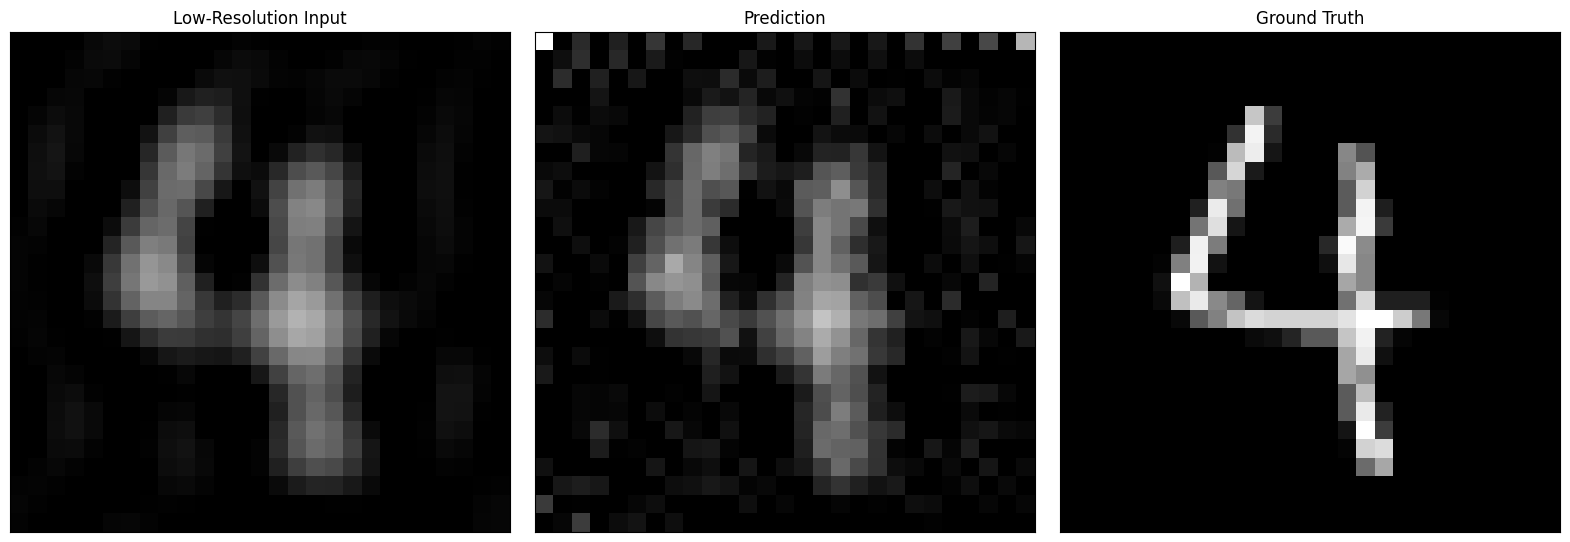

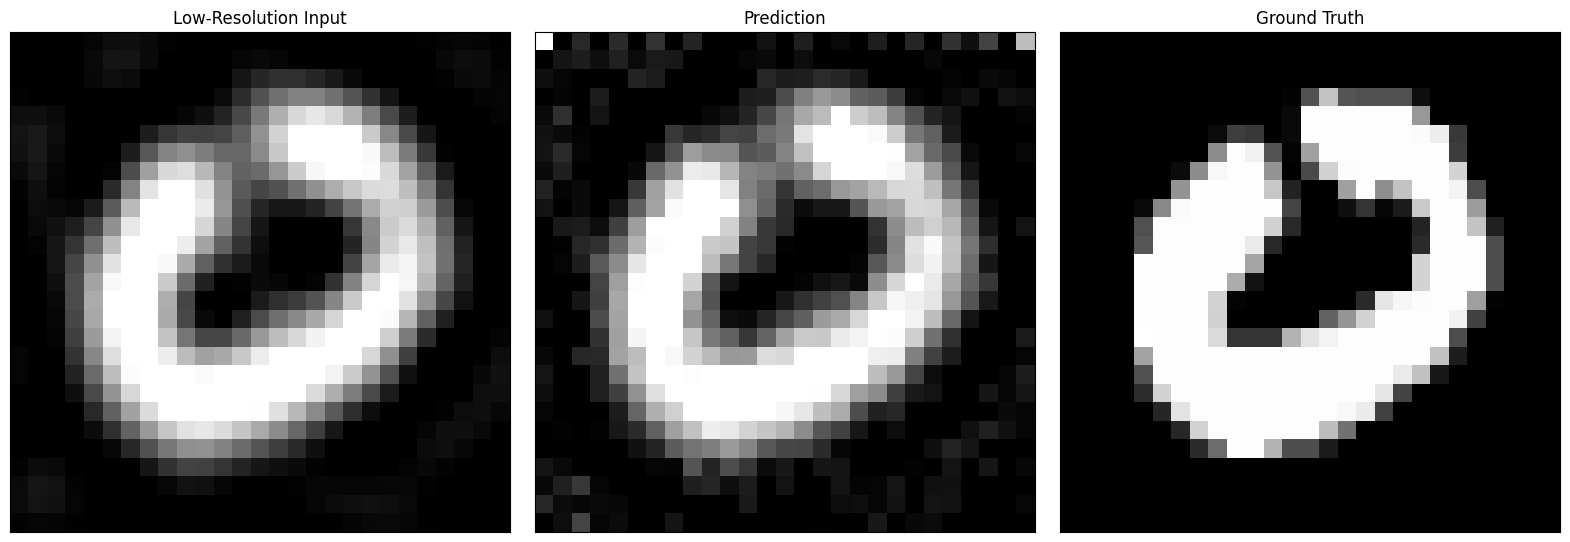

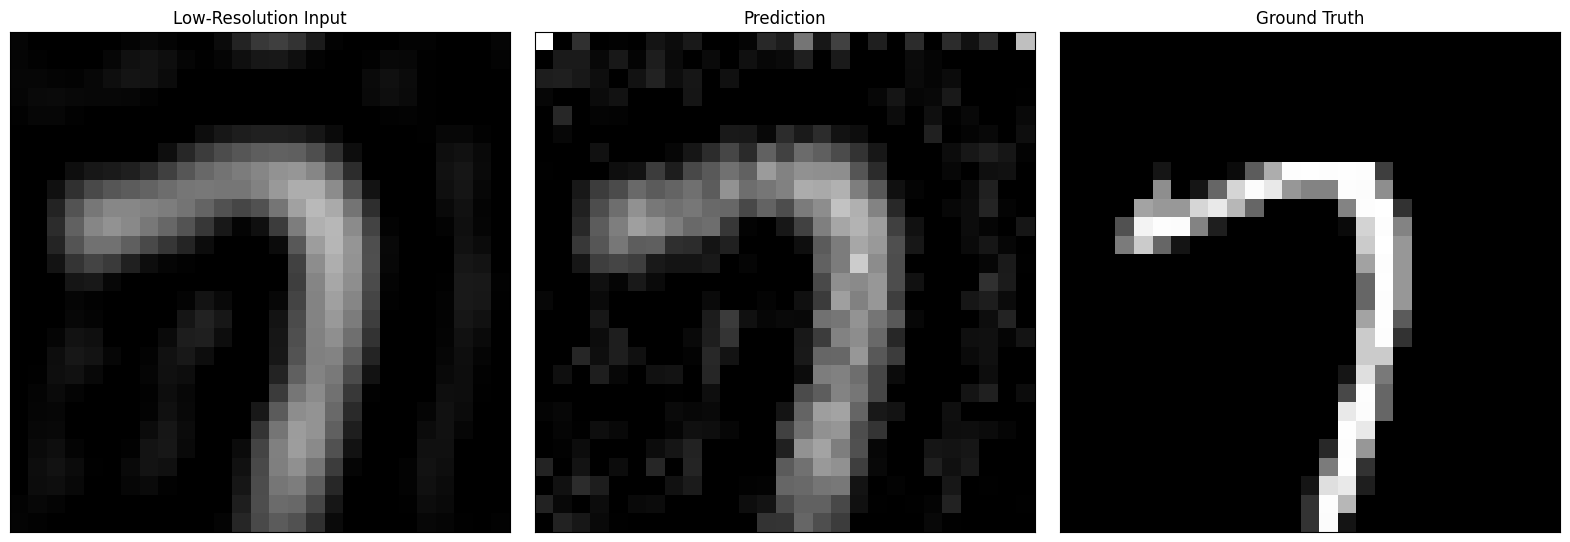

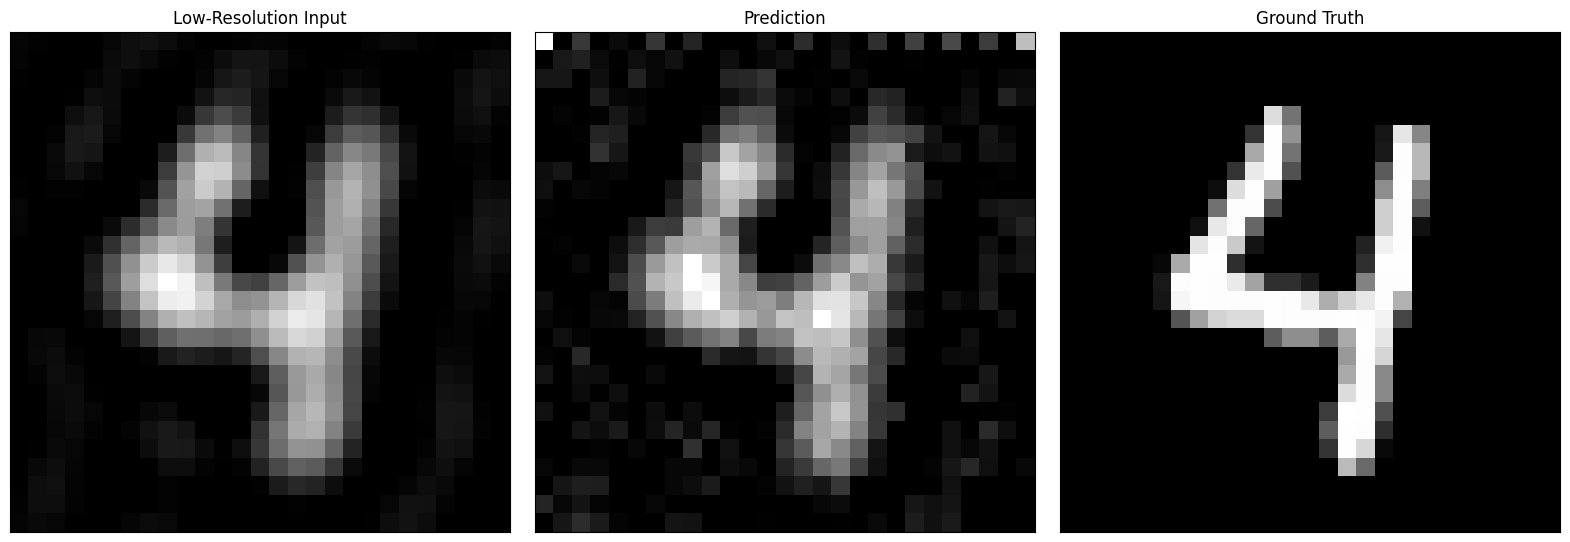

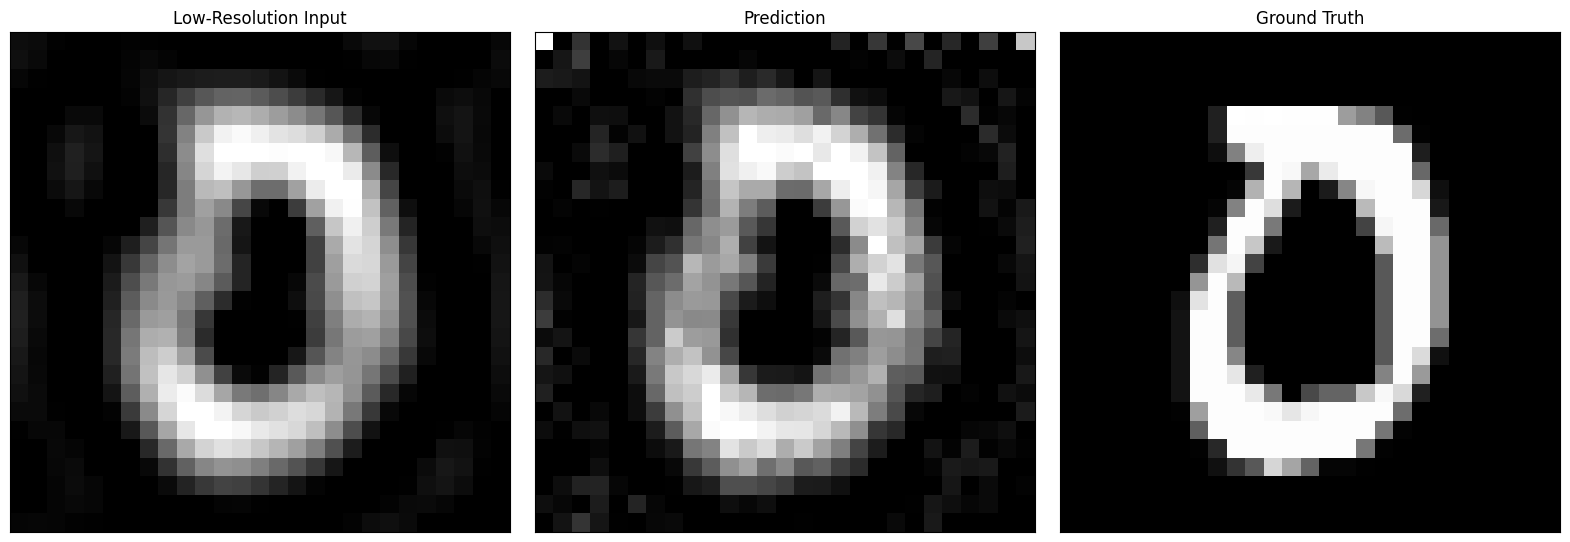

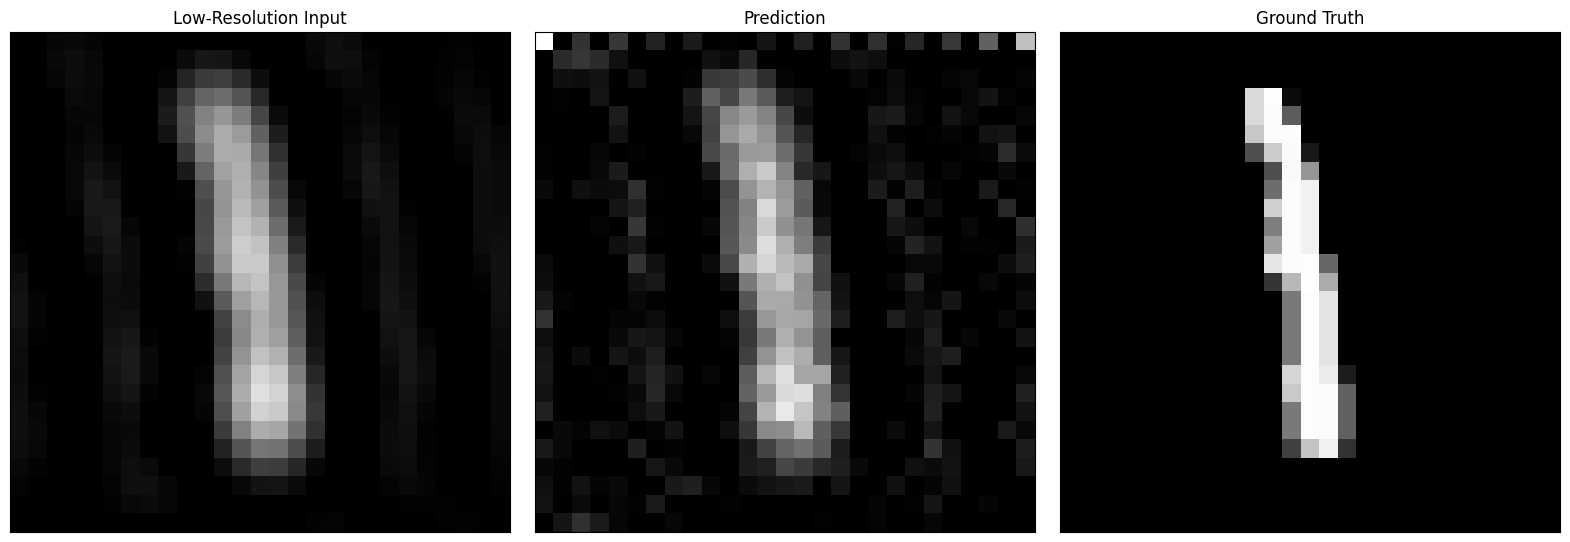

In [18]:
for i in range(30):
    sample = i
    fig = plt.figure(figsize=(31/2., 10/2.)) 
    gs = gridspec.GridSpec(1, 5, width_ratios=[10,0.5, 10, 0.5, 10]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[2])
    ax2 = plt.subplot(gs[4])
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                        hspace = 0, wspace = 0)

    ax0.xaxis.set_major_locator(plt.NullLocator())
    ax0.yaxis.set_major_locator(plt.NullLocator())
    ax0.imshow(lowres[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
    ax0.set_title('Low-Resolution Input');
    ax0.axis('equal');

    ax1.xaxis.set_major_locator(plt.NullLocator())
    ax1.yaxis.set_major_locator(plt.NullLocator())
    ax1.imshow(pred_img[sample], cmap='gray', vmin=gt[sample].min(), vmax=gt[sample].max())
    ax1.set_title('Prediction');
    ax1.axis('equal');


    ax2.xaxis.set_major_locator(plt.NullLocator())
    ax2.yaxis.set_major_locator(plt.NullLocator())
    ax2.imshow(gt[sample], cmap='gray')
    ax2.set_title('Ground Truth');
    ax2.axis('equal');